### Importing Necessary Packages and Checking GPU Compatability

In [1]:
import random
import numpy as np
import tensorflow as tf
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, ReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  ## To turn off debugging information 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 


Num GPUs Available:  1


### For Mac M1

In [2]:
# Ensure GPU memory growth is set before initialization
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid full allocation at startup
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ GPU memory growth enabled!")
    except RuntimeError as e:
        print(f"⚠️ GPU Memory Growth Error: {e}")

# Verify GPU availability
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


✅ GPU memory growth enabled!
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.keras import mixed_precision

# Enable mixed precision for faster GPU computation
mixed_precision.set_global_policy('mixed_float16')

print("✅ Mixed Precision Enabled: Using float16 for training")


✅ Mixed Precision Enabled: Using float16 for training


### Creating Image Generators for Each Data Split

In [4]:
# Creating generators for each data split

random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

# Define image parameters
img_size = (96, 96)  # Resize images to this size
batch_size = 32  # Number of images processed in one batch

# Create ImageDataGenerator with normalization

datagen = ImageDataGenerator(rescale=1.0/255)  # Normalizes to [0,1]

# Create training generator (72% of data)
train_generator = datagen.flow_from_directory(
    '/Your/Directory/Train,val,test/train',  # Path to dataset
    target_size=img_size,  # Resize all images to 150x150
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale" # Use 'categorical' for multi-class classification
)

# Create validation generator (18% of data)
val_generator = datagen.flow_from_directory(
    '/Your/Directory/Train,val,test/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale"
)

# Create testing generator (10% of data)
test_generator = datagen.flow_from_directory(
    '/Your/Directory/Train,val,test/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    color_mode="grayscale",
    shuffle=False # so predictions stay ordered later on
)

# Print class labels
print("Class Labels training set:", train_generator.class_indices)
print("Class Labels validation set:", val_generator.class_indices)
print("Class Labels testing set:", test_generator.class_indices)


Found 2592 images belonging to 4 classes.
Found 648 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Class Labels training set: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}
Class Labels validation set: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}
Class Labels testing set: {'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}


### Model Architecture and Training

In [5]:
# Setting seeds

random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

# Model architecture

# Input layer

input_layer = Input(shape=(96, 96, 1), name="Input_Layer") 

# First layer
x = Conv2D(32, (3,3), activation=None, padding="same")(input_layer)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

# Second layer
x = Conv2D(64, (3,3), activation=None, padding="same")(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

# Third layer
x = Conv2D(64, (3,3), activation=None, padding="same")(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

# Fourth layer
x = Conv2D(64, (3,3), activation=None, padding="same")(x)
x = ReLU()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.1)(x)

# Flatten before Dense layer
x = Flatten()(x)

# Fully connected layer
x = Dense(128, activation=None)(x)
x = LeakyReLU()(x)
x = Dropout(0.5)(x)  # Prevents overfitting

# Output layer
output_layer = Dense(4, activation="softmax")(x)  # 4 classes

# Build Model
model = Model(inputs=input_layer, outputs=output_layer, name="model_name") # replace with which name you want for model

# Compile model

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", 
    factor=0.5,  # Reduce LR by half
    patience=2,  # Wait 2 epochs before reducing
    min_lr=1e-6  # Don't go lower than this
)
# Stop when validation accuracy has not increased in four epochs
early_stopping = EarlyStopping(
    monitor="val_accuracy",  
    patience=4,          
    restore_best_weights=True  
)
# Train the model
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, reduce_lr])

Epoch 1/30


/Users/markusgerholm/miniconda3/envs/DL/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.3002 - loss: 1.3502 - val_accuracy: 0.4907 - val_loss: 1.1278 - learning_rate: 0.0010
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.4884 - loss: 1.0780 - val_accuracy: 0.5941 - val_loss: 0.8911 - learning_rate: 0.0010
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.6126 - loss: 0.8539 - val_accuracy: 0.6713 - val_loss: 0.7246 - learning_rate: 0.0010
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.7083 - loss: 0.7053 - val_accuracy: 0.7654 - val_loss: 0.5885 - learning_rate: 0.0010
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.7610 - loss: 0.5937 - val_accuracy: 0.7978 - val_loss: 0.5328 - learning_rate: 0.0010
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.7773 - loss: 0.5306 - val_accuracy: 0.8302 - val_loss: 0.4760 - learning_rate: 0.0010
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8574 - loss: 0.3856 - val_accuracy: 0.82

### Model Evaluation

In [6]:
random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

# Evaluating model performance
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

# Print results
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Best Validation Accuracy: {max(val_acc):.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Final Training Accuracy: 0.9830
Best Validation Accuracy: 0.9306
Test Accuracy: 0.9528


### Plotting Model Performance

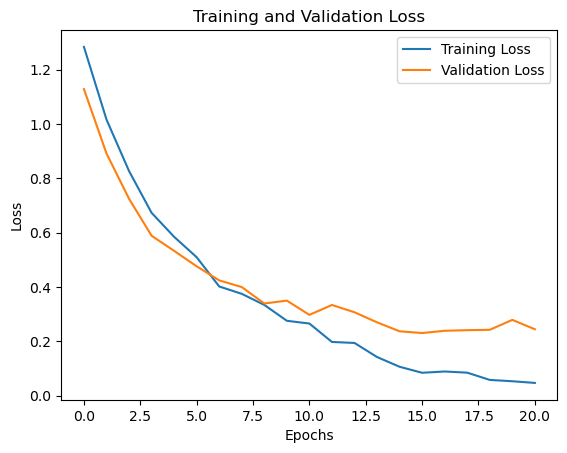

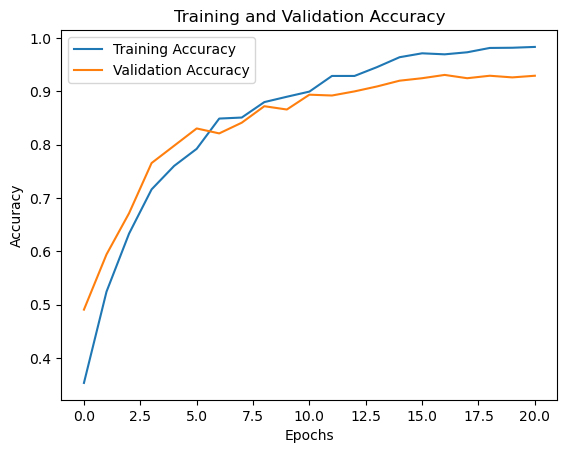

In [7]:
#Plot Training & Validation Accuracy/Loss
import matplotlib.pyplot as plt
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Examples of Predictions and Wether They are True

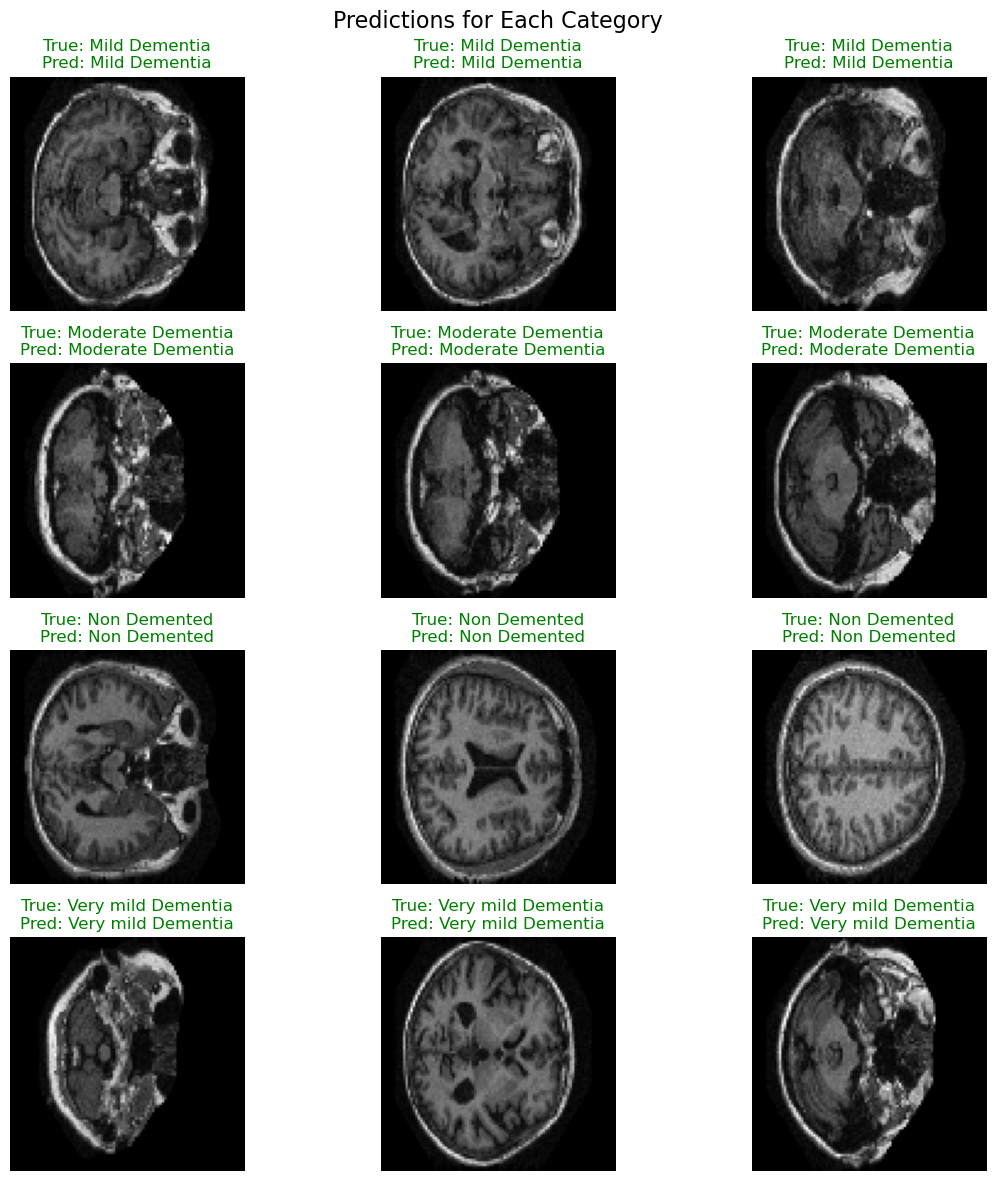

In [8]:


# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Function to plot 3 images per category with predictions
def plot_predictions(model, test_generator, class_labels, num_images=3):
    fig, axes = plt.subplots(len(class_labels), num_images, figsize=(12, 12))
    fig.suptitle("Predictions for Each Category", fontsize=16)
    
    for i, class_label in enumerate(class_labels):
        count = 0
        for batch_images, batch_labels in test_generator:
            predictions = model.predict(batch_images, verbose=0)
            predicted_classes = np.argmax(predictions, axis=1)
            true_classes = np.argmax(batch_labels, axis=1)
            
            for j in range(len(batch_images)):
                if true_classes[j] == i and count < num_images:
                    ax = axes[i, count]
                    ax.imshow(batch_images[j].squeeze(), cmap='gray')  # Since images are grayscale
                    ax.axis('off')
                    pred_label = class_labels[predicted_classes[j]]
                    true_label = class_labels[true_classes[j]]
                    
                    # Set title color based on prediction correctness
                    title_color = 'green' if pred_label == true_label else 'red'
                    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
                    count += 1
                if count >= num_images:
                    break
            if count >= num_images:
                break
    plt.tight_layout()
    plt.show()

# Call function to plot predictions
plot_predictions(model, test_generator, class_labels)


### Confusion Matrix

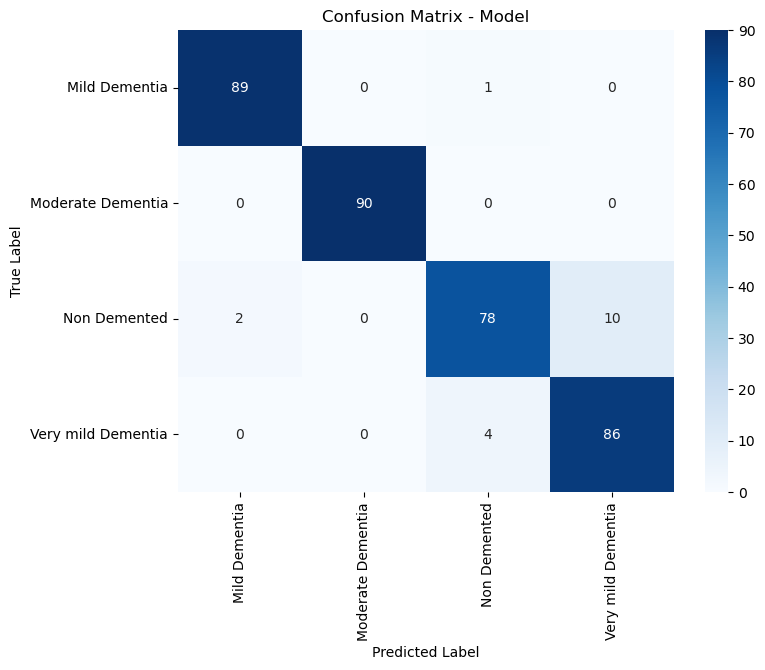

In [9]:
# Confusion matrix

# Get class labels
label_names = list(test_generator.class_indices.keys())

# Get true labels from test_generator
y_true = test_generator.classes  # ✅ Extracts true labels directly

# Get predictions in one batch instead of looping
y_pred_probs = model.predict(test_generator, verbose=0)  # ✅ MUCH FASTER!
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)

plt.xticks(rotation=90)  # ✅ Rotate x-axis labels vertically
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Model")
plt.show()


### Classification Report

In [10]:
# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
                     precision    recall  f1-score   support

     Mild Dementia       0.98      0.99      0.98        90
 Moderate Dementia       1.00      1.00      1.00        90
      Non Demented       0.94      0.87      0.90        90
Very mild Dementia       0.90      0.96      0.92        90

          accuracy                           0.95       360
         macro avg       0.95      0.95      0.95       360
      weighted avg       0.95      0.95      0.95       360

